# Game Rules

## Mechanics

1. Roll a 6-Sided Dice
2. Convert the rolls using the [damage matrix](#Damage%20Matrix)

## Rounds

A round consists of 3 rolls

## Winning

- Add each roll
- A score exactly 21 wins. _(ex. 3,3,3,3,3,3,3 [21])_
- Exceeding 21 _(ex. 3,3,2,2,3,3,3,3 [22])_ your score is reduced to 15

## Damage Matrix

| Damage | Dice Roll |
| :----: | :-------: |
|   1    |  1 or 2   |
|   2    |  3 or 4   |
|   3    |  5 or 6   |


# Dice Game Logic Proof

The objective of this is to evaluate a game design to ensure credibility as well as future game economy.

## Objectives

1. Calculate
   1. The average amount of rolls needed to win
      - Also Rounds (rolls / 3) _rounded down_
   2. The maximum amount of rolls needed to win
      - Also Rounds (rolls / 3) _rounded down_
   3. How many times a tie happens in each game
   4. How many times more than one winner (not the same as a _perfect_ tie)
2. Variables
   1. Number of Players
      - 2-5
3. Visualize
   1. Table
   2. Graph

---


## Initial imports


In [1]:
# Setup the environment
import numpy as np
import pandas as pd
from typing import Any


## Setup a function to slice the arrays based upon the rules


In [2]:
def get_win_arrays(dice_array: np.ndarray) -> list:
    """Returns a list has been sliced based upon the game logic

    Args:
        dice_array (np.ndarray): random array of rolls

    Returns:
        list: a list sliced to the game winning length
    """
    damage_matrix = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3}

    new_array = []
    for player_index, rolls in enumerate(dice_array):
        total_score = 0
        game_win_index = 0
        for roll_index, roll in enumerate(rolls):
            total_score += damage_matrix[roll]
            if total_score == 21:
                game_win_index = roll_index + 1
                break
            if total_score > 21 and game_win_index == 0:
                total_score = 15
        if game_win_index > 0:
            new_array.append(dice_array[player_index, :game_win_index].tolist())
    return new_array


### This is how we get the game stats we need for the table


In [3]:
# Define the function to find more than one winner


def game_stats(game_rolls_array: list, return_len_array: bool = False) -> dict[str, Any]:
    """This is the table building part of the logic

    Args:
        game_rolls_array (list): This is a dice roll array that has been sliced at the winning index

    Returns:
        dict[str, Any]: this has the results of each item
    """
    user_rolls_len = []
    total_duplicates = 0
    perfect_dupe = 0
    for game_rolls in game_rolls_array:
        user_rolls_len.extend(len(user_rolls) for user_rolls in game_rolls)
        check_dupes = []
        check_dupes.extend(len(user_rolls) for user_rolls in game_rolls)
        check_dupes_array = np.array(check_dupes)
        uniques, uniq_idx, counts = np.unique(
            check_dupes_array, return_index=True, return_counts=True
        )
        duplicates = check_dupes_array[uniq_idx[counts >= 2]]
        if len(duplicates > 0):
            total_duplicates += 1
        if len(game_rolls) == counts[0] and len(game_rolls) > 2:
            perfect_dupe += 1
    user_rolls_len = np.array(user_rolls_len)
    if return_len_array:
        return user_rolls_len
    return {
        "average": user_rolls_len.mean(dtype=int),
        "min": user_rolls_len.min(),
        "max": user_rolls_len.max(),
        "no_winner": 0 in user_rolls_len,
        "total_games": len(game_rolls_array),
        "total_dupes": total_duplicates,
        "perfect_dupes": perfect_dupe,
    }


---
## Here we start generating the test data for all future tests!
---


In [4]:
def create_dice_rolls_array(players: int, rolls: int, games: int) -> list:
    """Creates an array of dice rolls based upon the constraints arguments

    Args:
        players (int): How many players
        rolls (int): Total number of rolls (should be high enough to not produce no wins)
        games (int): How many games

    Returns:
        list: This is the returned list that we use later
    """
    dice_rolls_array = []
    # Seed the number of games {number_of_games} and slice the arrays appropriately.

    for x in range(games):
        seed = str(x) + str(players) + str(rolls) + str(games)
        rng = np.random.default_rng(seed=int(seed) ** 2)
        dice_rolls_array.append(
            get_win_arrays(
                rng.integers(1, 7, (rolls * players)).reshape(players, rolls)
            )
        )
    # Result a 2 dimensional array with {number_players}, {number_of_rolls}
    return dice_rolls_array


## The following Parameters are used for the actual logic proof


In [5]:
# Set the parameters
num_of_rolls: int = 100
num_of_games: int = 200000
max_num_of_players: int = 5


In [6]:
dice_rolls_dataframe = pd.DataFrame()
for x in reversed(range(1, max_num_of_players + 1)):
    dice_rolls_dataframe[f'Players {x}'] = pd.Series(game_stats(create_dice_rolls_array(x, num_of_rolls, num_of_games),return_len_array=True))
    print(f'Players {x}', game_stats(create_dice_rolls_array(x, num_of_rolls, num_of_games)))

Players 5 {'average': 14, 'min': 7, 'max': 76, 'no_winner': False, 'total_games': 200000, 'total_dupes': 120752, 'perfect_dupes': 24}
Players 4 {'average': 14, 'min': 7, 'max': 82, 'no_winner': False, 'total_games': 200000, 'total_dupes': 84014, 'perfect_dupes': 236}
Players 3 {'average': 14, 'min': 7, 'max': 79, 'no_winner': False, 'total_games': 200000, 'total_dupes': 47490, 'perfect_dupes': 1849}
Players 2 {'average': 14, 'min': 7, 'max': 78, 'no_winner': False, 'total_games': 200000, 'total_dupes': 16776, 'perfect_dupes': 0}
Players 1 {'average': 14, 'min': 7, 'max': 76, 'no_winner': False, 'total_games': 200000, 'total_dupes': 0, 'perfect_dupes': 0}


In [7]:
dice_rolls_dataframe.describe()

,Players 5,Players 4,Players 3,Players 2,Players 1
count,1000000.000000,800000.000000,600000.000000,400000.000000,200000.000000
mean,14.044259,14.055370,14.050597,14.058423,14.031025
std,5.011166,5.045236,5.030368,5.025721,5.022691
min,7.000000,7.000000,7.000000,7.000000,7.000000
25%,11.000000,11.000000,11.000000,11.000000,11.000000
50%,13.000000,13.000000,13.000000,13.000000,13.000000
75%,16.000000,16.000000,16.000000,16.000000,16.000000
max,76.000000,82.000000,79.000000,78.000000,76.000000


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

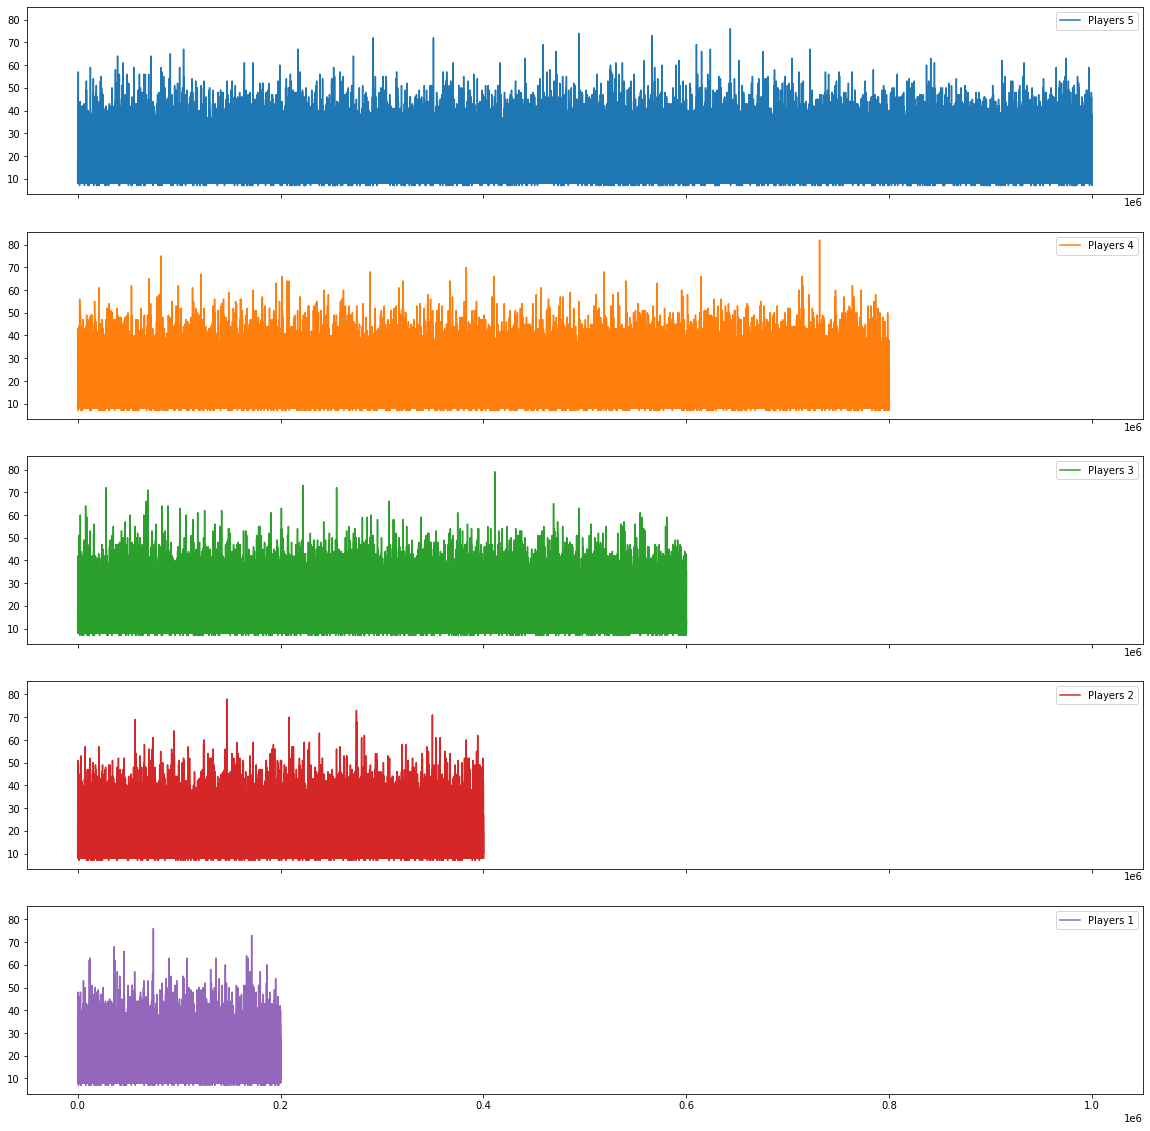

In [14]:
dice_rolls_dataframe.plot(subplots=True, figsize=(20,20), sharey=True)

<AxesSubplot:xlabel='Players 4', ylabel='Players 5'>

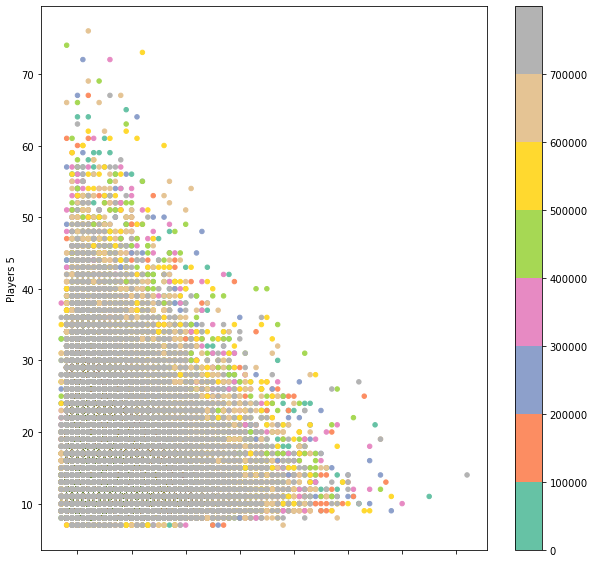

In [24]:
dice_rolls_dataframe.plot.scatter(x='Players 4',y='Players 5',figsize=(10,10), c=dice_rolls_dataframe.index, colormap="Set2")

---

# Below is where we start the self-tests for the logic to ensure that all the functions are correct and we have credible results

## Creating random rolls to be used in tests.


In [8]:
def test_rng(rolls: int, players: int):
    """Generate a seeded ndarray for the tests

    Args:
        rolls (int): how many rolls
        players (int): how many players

    Returns:
        ndArray: numpy array

    >>> test_rng(5,5)
    array([[5, 2, 5, 1, 2],
           [4, 6, 1, 1, 4],
           [6, 5, 5, 1, 4],
           [1, 1, 3, 6, 6],
           [3, 6, 1, 2, 4]])
    """
    test_rng = np.random.default_rng(2022)
    return test_rng.integers(1, 7, (rolls * players)).reshape(players, rolls)


In [9]:
def test_get_win_arrays():
    """Tests the win arrays
    Returns:
        int: 1 if passed

    >>> test_get_win_arrays()
    1
    """
    # Provide the known winning lengths for the test (to test the function)
    test_array = [11, 11, 15, 10, 10]

    return next(
        (
            0
            for test_index, test_rolls in enumerate(get_win_arrays(test_rng(100, 5)))
            if test_array[test_index] != len(test_rolls)
        ),
        1,
    )


In [10]:
def test_game_logic_tester():
    """This tests the game logic
    Returns:
        int: 1 if passed
    >>> test_game_logic_tester()
    1

    """
    game_gen = []
    total_test_games = 5

    game_gen.extend(get_win_arrays(test_rng(100, 5)) for _ in range(total_test_games))

    perfect_dupe_array = [
        [
            [5, 2, 5, 1, 2, 4, 6, 1, 1, 4],
            [2, 1, 1, 2, 3, 4, 5, 5, 4, 4],
            [5, 2, 4, 5, 4, 4, 5, 4, 4, 5],
            [3, 5, 3, 2, 4, 6, 3, 6, 4, 2],
            [5, 2, 2, 6, 4, 3, 1, 5, 4, 5],
        ]
    ]
    perfect_dupes = game_stats(perfect_dupe_array)
    array_of_lengths_values = game_stats(game_gen)
    if (
        array_of_lengths_values.get("total_dupes") == total_test_games
        and array_of_lengths_values.get("average") == 11
        and array_of_lengths_values.get("min") == 10
        and array_of_lengths_values.get("max") == 15
        and perfect_dupes.get("perfect_dupes") == 1
    ):
        return 1
    else:
        return 0


## This is using doctests to simplify tests


In [11]:
import doctest

doctest.testmod(report=True)


TestResults(failed=0, attempted=3)